**Autor:** José Romualdo Villalobos Pérez

**ID:** 000294087

## El problema:

Un banco alemán desea establecer políticas de mercadeo según el tipo de cliente. Para esto se desean identificar tipos de clientes de una base de datos de 1000 registros con 20 atributos cada uno.

In [110]:
#Importar librerias
# %matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import itertools
import pandas as pd
from kmodes.kmodes import KModes
from sklearn import datasets, cluster
from sklearn.metrics import confusion_matrix, classification_report
from mpl_toolkits.mplot3d import Axes3D

from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold

from sklearn.preprocessing import normalize


# Cargar datos

In [47]:
# Credits
credits = pd.read_csv('german-credit-balanced.csv')
creditsX = credits.iloc[:, :-1].values
creditsX

creditsY = credits.iloc[:, 20].values
creditsY
# creditsX

# Discretized credits
# creditsDisc = pd.read_csv('german-credit-discretized.csv')
# creditsDisc.iloc[:5, :]

array(['good', 'bad', 'good', ..., 'bad', 'bad', 'bad'], dtype=object)

# Haciendo los clusters con KMeans

Se hacen 2 clusters porque solo tenemos dos clases (cliente bueno y cliente malo)

In [79]:
# Para evitar un resultado en mionimos locales descomentar
# la siguiente linea
np.random.seed(2)

# for clustering categorical data we are going to use kmodes instead of kmeans
km = KModes(n_clusters=2, init='Huang', n_init=5, verbose=1)
clusters = km.fit_predict(creditsX)
# Print the cluster centroids
print(km.cluster_centroids_)
print(km.labels_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 349, cost: 11850.0
Run 1, iteration: 2/100, moves: 202, cost: 11764.0
Run 1, iteration: 3/100, moves: 64, cost: 11764.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 382, cost: 12111.0
Run 2, iteration: 2/100, moves: 174, cost: 12029.0
Run 2, iteration: 3/100, moves: 5, cost: 12027.0
Run 2, iteration: 4/100, moves: 0, cost: 12027.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 303, cost: 11898.0
Run 3, iteration: 2/100, moves: 0, cost: 11898.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 215, cost: 11938.0
Run 4, iteration: 2/100, moves: 67, cost: 11938.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 234, cost: 1175

# Evaluando rendimiento

In [80]:
# Converts factor variable to numeric
creditsYBin = [1 if y == 'good' else 0 for y in creditsY]

correct_labels = sum(creditsYBin == km.labels_)

print("Resultado: {} datos de {} Ejemplos fueron correctamente etiquetados (labeled).".format(correct_labels, creditsY.size))

Resultado: 817 datos de 1300 Ejemplos fueron correctamente etiquetados (labeled).


In [87]:
labels = km.labels_
class_names = np.array(['good', 'bad'])
cm = confusion_matrix(creditsYBin, labels)
print('\n Matriz de confusion simple:')
print(cm)
print(classification_report(labels, creditsYBin, target_names=class_names))


 Matriz de confusion simple:
[[491 109]
 [374 326]]
             precision    recall  f1-score   support

       good       0.82      0.57      0.67       865
        bad       0.47      0.75      0.57       435

avg / total       0.70      0.63      0.64      1300



In [85]:
# funcion extraida de http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

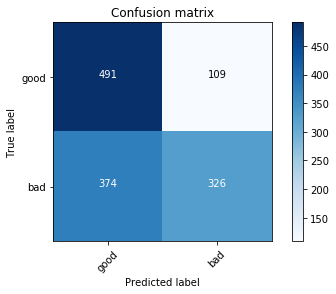

In [88]:
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')

# Expectation maximization (EM)

In [94]:
# Funcion para graficar elipses
colors = ['navy', 'turquoise', 'darkorange']

def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)

In [124]:
X_train = creditsX[:, [1, 4, 15]]

y_train = creditsY

X_train

n_classes = len(np.unique(y_train))

for i in range(3):
    X_train[:, i] = X_train[:,i] / np.linalg.norm(X_train[:, i]);

X_train

array([[0.006702012569812486, 0.00711769226587151, 0.036862921676318675],
       [0.053616100558499885, 0.0362338637076145, 0.018431460838159337],
       [0.013404025139624971, 0.012761918724779029, 0.018431460838159337],
       ...,
       [0.05139589916344992, 0.02953269286274636, 0.026268683869692232],
       [0.040212075418874914, 0.05056563235044614, 0.018431460838159337],
       [0.04518335020964018, 0.011229153870929131, 0.018431460838159337]],
      dtype=object)

In [129]:
# Try GMMs using different types of covariances.
estimators = dict((cov_type, GaussianMixture(n_components=n_classes,
                   covariance_type=cov_type, max_iter=20, random_state=0))
                  for cov_type in ['spherical', 'diag', 'tied', 'full'])

n_estimators = len(estimators)

plt.figure(figsize=(6 * n_estimators // 2, 10))
plt.subplots_adjust(bottom=.01, top=0.95, hspace=.15, wspace=.05,
                    left=.01, right=.99)


for index, (name, estimator) in enumerate(estimators.items()):
    # Since we have class labels for the training data, we can
    # initialize the GMM parameters in a supervised manner.
    estimator.means_init = np.array([X_train[y_train == i].mean(axis=0)
                                    for i in range(n_classes)])

    # Train the other parameters using the EM algorithm.
    estimator.fit(X_train)

    h = plt.subplot(2, n_estimators // 2, index + 1)
    make_ellipses(estimator, h)

    for n, color in enumerate(colors):
        data = iris.data[iris.target == n]
        plt.scatter(data[:, 0], data[:, 1], s=0.8, color=color,
                    label=inp.array([]))
    # Plot the test data with crosses
    for n, color in enumerate(colors):
        data = X_test[y_test == n]
        plt.scatter(data[:, 0], data[:, 1], marker='x', color=color)

    y_train_pred = estimator.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
    plt.text(0.05, 0.9, 'Train accuracy: %.1f' % train_accuracy,
             transform=h.transAxes)

    plt.xticks(())
    plt.yticks(())
    plt.title(name)

plt.legend(scatterpoints=1, loc='lower right', prop=dict(size=12))

plt.show()

/home/jose/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice.
/home/jose/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

# Cobweb

In [138]:
from random import shuffle
from random import seed

from concept_formation.cobweb3 import Cobweb3Tree
from concept_formation.cluster import cluster
from sklearn.decomposition import PCA
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import adjusted_rand_score
from concept_formation.datasets import load_iris

In [142]:
seed(0)
irises = load_iris()
shuffle(irises)

tree = Cobweb3Tree()
irises_no_class = [{a: iris[a] for a in iris if a != 'class'} for iris in irises]
clusters = cluster(tree, creditsX)[0]
iris_class = [iris[a] for iris in irises for a in iris if a == 'class']
ari = adjusted_rand_score(clusters, creditsY)

dv = DictVectorizer(sparse=False)
iris_X = dv.fit_transform([{a:credits[a] for a in iris if a != 'class'} for iris in irises])
pca = PCA(n_components=2)
iris_2d_x = pca.fit_transform(creditsY)

colors = ['b', 'g', 'r', 'y', 'k', 'c', 'm']
shapes = ['o', '^', '+']
clust_set = {v:i for i,v in enumerate(list(set(clusters)))}
class_set = {v:i for i,v in enumerate(list(set(iris_class)))}

for class_idx, class_label in enumerate(class_set):
    x = [v[0] for i,v in enumerate(iris_2d_x) if iris_class[i] == class_label]
    y = [v[1] for i,v in enumerate(iris_2d_x) if iris_class[i] == class_label]
    c = [colors[clust_set[clusters[i]]] for i,v in enumerate(iris_2d_x) if
         iris_class[i] == class_label]
    plt.scatter(x, y, color=c, marker=shapes[class_idx], label=class_label)

plt.title("COBWEB/3 Iris Clustering (ARI = %0.2f)" % (ari))
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.legend(loc=4)
plt.show()

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices